In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import random
import itertools  
from tqdm import tqdm
from collections import defaultdict
import heapq 
import copy
from collections import deque

## Get Data to analyze

Before to answer the RQs let's read and manage the datasets, in order to fit it for our purposes.

In [6]:
df = pd.read_csv('wikigraph_reduced.csv', sep = '\t', header = None)
df.columns = ['u','from', 'to']
df.head()

,u,from,to
0,NaN,0,1
1,796.0,95,1185516
2,909.0,108,1059989
3,910.0,108,1062426
4,911.0,108,1161925


Let's change the dataset (df) for our purpose

In [7]:
df = df[['from', 'to']]
df = df.drop([0])
df.reset_index(drop=True)
df.head()

,from,to
1,95,1185516
2,108,1059989
3,108,1062426
4,108,1161925
5,134,541222


---------------------------------------------------------------

One article/node might belong to a single category or multiple ones. In the case of multiple appearance, we choose to break the ties uniformly at random.

In [8]:
categories_dict = {}

In [9]:
# This is an inverted index, as dict, in which for each node(key) there is a list of category(values)

categories_file = open('wiki-topcats-categories.txt' , 'r')
for row in categories_file:
    row_list = row.split()
    category = row_list[0][9:-1]
        
    for page in row_list[1:]:
        if page not in categories_dict:
            categories_dict[page] = []
            
        categories_dict[page].append(category)

In [10]:
for page in categories_dict:
    categories_list = categories_dict[page]
    category_idx = random.randint(0, len(categories_list)-1)
    categories_dict[page] = categories_list[category_idx]

Let's import the names of the pages

In [11]:
pagesnames = pd.read_csv("wiki-topcats-page-names.txt",sep='\t',header=None) 
pagesnames = pd.DataFrame( [ [page.split(' ')[0],' '.join(page.split(' ')[1:])] for page in pagesnames[0]])

In [12]:
#Let's create a list 'catgorie' in which there are all the categories in the Graph G

f = df['from'].tolist()
t = df['to'].tolist()
categorie = []
f = list(set(f))
t = list(set(t))
tot = f + t
tot = list(set(tot))
for x in tot:
    x = str(x)
    if x in categories_dict:
        categoria = categories_dict[x]
        categorie.append(categoria)

categorie = list(set(categorie))

### Start to create our graph

# RQ1

Build the graph G=(V, E), where V is the set of articles and E the hyperlinks among them

In [13]:
G = nx.from_pandas_edgelist(df, 'from', 'to', create_using = nx.DiGraph)

- Is the graph directed?

Yes, by using the function *nx.DiGrapg* we will create a directed graph, but let's prove it!


Let's take as example the edge between nodes 108 and 1059989. A we can see the edge goes from 108 to 1059989 and there is not an edge with the inverse path. So we can say that the graph is **directed**

In [ ]:
df_test = df[df['from'] == 108]
print(df_test)
df_test2 = df[df['from']==1059989]
print(df_test2)

   from       to
2   108  1059989
3   108  1062426
4   108  1161925
           from       to
212308  1059989   137144
212309  1059989   147492
212310  1059989   635998
212311  1059989   688704
212312  1059989   688741
212313  1059989  1015403
212314  1059989  1054071
212315  1059989  1056157
212316  1059989  1059782
212317  1059989  1059988
212318  1059989  1060238
212319  1059989  1060884
212320  1059989  1141095
212321  1059989  1161925
212322  1059989  1162809
212323  1059989  1163419
212324  1059989  1164977
212325  1059989  1632839


- How many articles are we considering?


In [ ]:
n_articles = G.number_of_nodes()
n_articles

98343

Let's prove it!

In [ ]:
fr = df['from'].tolist()
fr = list(dict.fromkeys(fr))


to = df['to'].tolist()
to = list(dict.fromkeys(to))

VV = set(to + fr)
print(len(VV))

98343


- How many hyperlinks between pages exist?


In [ ]:
n_hyperlinks = G.number_of_edges()
print(n_hyperlinks)

if n_hyperlinks == len(df):
    print('This is the right number of hyperlinks, proved:', n_hyperlinks)

483094
This is the right number of hyperlinks, proved: 483094


- Compute the average number of links in an arbitrary page.

In [ ]:
links = df.groupby('from').to.count().tolist()

In [ ]:
average_n_link = np.mean(links)
average_n_link

5.313396392432908

<br><br>
* Compute the average number of links in an arbitrary page. What is the graph density? Do you believe that the graph is dense or sparse? Is the graph dense?

To find Density of a Graph:    $d = \frac{m}{n(n-1)}$<br>
<strong>n</strong> is the number of Nodes<br>
<strong>m</strong> is the number of Edges<br>

In [ ]:
n = G.number_of_nodes()
m = G.number_of_edges()
density = m /(n*(n-1))
print("Density of the Graph:",density)

Density of the Graph: 4.9951571365597335e-05


Considering that the *density* has 1 as max value, according to the calculated density we think this graph is sparse.

- Visualize the nodes' degree distribution

In [ ]:
links2 = df.groupby('from').to.count()

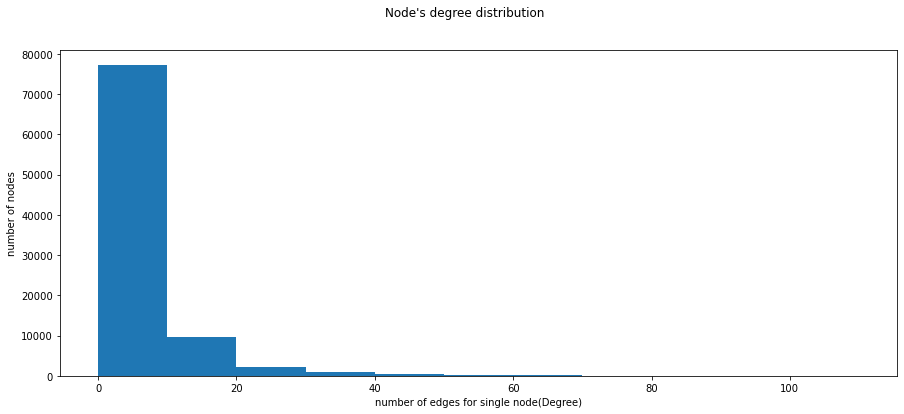

In [ ]:
plt.figure(figsize=(15, 6))

b = [0,10,20,30,40,50,60,70,80,90,100,110]


plt.hist(links2, bins=b)
plt.suptitle("Node's degree distribution")
plt.xlabel('number of edges for single node(Degree)')
plt.ylabel('number of nodes')

plt.show()

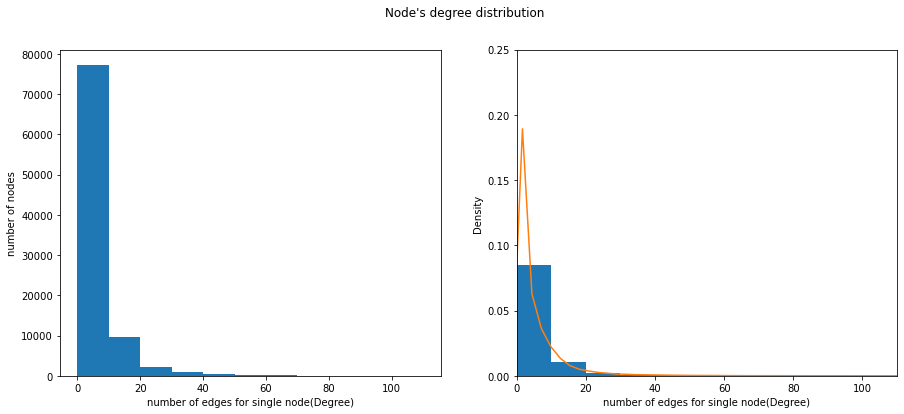

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15, 6))
fig.suptitle("Node's degree distribution")

#fig.xlabel('number of edges for single node')
#fig.ylabel('number of nodes')

ax1.set(xlabel='number of edges for single node(Degree)', ylabel='number of nodes')

b = [0,10,20,30,40,50,60,70,80,90,100,110]
ax1.hist(links2, bins=b)

ax2.set(xlabel='number of edges for single node(Degree)')
ax2.set_ylim(0, .25)
ax2.set_xlim(0,110)
links2.plot(kind = "hist", density = True, bins = b) 
links2.plot(kind = "kde")


<br><br>

# RQ2 
##### <br><br> Define a function that takes in input:
* A page v<br>
* A number of clicks d and returns the set of all pages that a user can reach within d clicks.<br>

<br>
To find all the possible pages to be visited by a number of clicks from given page we have used <strong>Breath First Traversal</strong> Algoritham.

In [11]:
"""
* Breath First Traversal Algorithams will Traverse through the Graph in Level wise 
(levels will be considered as clicks here)
* For the start we have initialized the list and transformed it to the Queue
* Queue --> FIFO Data structure (First In First Out)
* For the record of clicks and Pages we've Initialized a Dictionary clickRecord
* If any pages is not avaliable in the Graph it'll raise an error that the Page not found in the Graph
"""
def findPagesOnClicks(Graph, Page, Clicks): 
    queue = deque([Page]) 
    clickRecord = {Page: 0}
    try:
        Graph[Page]
    except:
        print("Error 404 Page not found in the Graph")
        return None
    while queue: 
        currentPage = queue.popleft() 
        if clickRecord[currentPage] == Clicks: 
            break 
        for linkedPages in Graph[currentPage]: 
            if linkedPages in clickRecord: 
                continue 
            queue.append(linkedPages) 
            clickRecord[linkedPages] = clickRecord[currentPage] + 1
    return clickRecord

In [16]:
toShow = 0
v = int(input("Enter a Page: ")) #95
d = int(input("Enter a clicks: ")) #3

pages = findPagesOnClicks(G,v,d)
if pages is not None:
    print("\nFrom Page:",v,"\nTitle:",pagesnames.at[v,1],"\nBy:",d,"clicks\nYou can explore",len(pages),"different Pages\n") 
    for page in pages:
        if toShow == 20:
            break
        toShow += 1
        print("Page:",page,"\t\t Page Title:",pagesnames.at[page,1])
    if toShow < len(pages):
        print("...")

Enter a Page: 95
Enter a clicks: 3

From Page: 95 
Title: This Way (Hana Pestle album) 
By: 3 clicks
You can explore 132 different Pages

Page: 95 		 Page Title: This Way (Hana Pestle album)
Page: 1185516 		 Page Title: Marty O'Brien
Page: 150451 		 Page Title: 22nd Century Lifestyle
Page: 1062563 		 Page Title: Lindsay Lohan
Page: 1178930 		 Page Title: Marilyn Manson
Page: 1184017 		 Page Title: Ma
Page: 1184695 		 Page Title: Kelly Clarkson
Page: 1761109 		 Page Title: A Rhyme & Reason
Page: 1177884 		 Page Title: Andy Johns
Page: 110209 		 Page Title: Tina Fey
Page: 688300 		 Page Title: Deep Throat (film)
Page: 943780 		 Page Title: Steve Rhodes (journalist)
Page: 1057618 		 Page Title: Niagara (1953 film)
Page: 1058061 		 Page Title: The Parent Trap (1961 film)
Page: 1058123 		 Page Title: Confessions of a Teenage Drama Queen
Page: 1058832 		 Page Title: Just My Luck (2006 film)
Page: 1059127 		 Page Title: Georgia Rule
Page: 1059279 		 Page Title: Freaky Friday (2003 film)
Page:

<br><br>
### RQ3<br>
##### Define a function that takes in input:
<br>

* a category <b>C</b><br>
* a set of pages in <b>C, p = {p1, ..., pn}</b> and returns the minimum number of clicks required to reach all pages in p, starting from the page v, corresponding to the most central article, according to the in degree centrality, in C.<br>
<br>

##### Consider that:
The algorithm needs to handle the case that the graph is not connected, thus not all the pages in p are reachable from v. In such scenario, it is enough to let the program give in output the string "Not possible".<br>
Since we are dealing with graph exploration, you can pass more than once on the same page pi.
Since the problem’s complexity is high, consider to provide just an approximation/heuristic solution for the problem.<br>
You can use whatever metrics of centrality.

In [17]:
"""
* First Step for the given problem is to get all the pages within given Categories.
* As "categories_dict" have all the categories and their related pages, So we have took all the pages
corresponding to the category and put them all into list P.
* and then we have find the In Degree centrality of the graph using the build in fucntion of Networkx 
which is "in_degree_centrality", and then separeted the specific pages and their In Degree Centrality
values.
* And then selected the page as V with the highest In Degree Centrality.
* And Finally a for loop through the Pages and using BFS (Breath First Search) to find the pages are also
making records of their clicks from most In Degree Central page V.
"""

def findClickFromVtoP(Graph, v, p,limit): 
    queue = deque([v]) 
    clickRecord = {v: 0}
    try:
        Graph[v]
    except:
        print("Error 404 Page not found in the Graph")
        return None
    while queue: 
        currentPage = queue.popleft() 
        if clickRecord[currentPage] == limit: 
            return []
            #break 
        for linkedPages in Graph[currentPage]: 
            if linkedPages in clickRecord: 
                continue 
            queue.append(linkedPages) 
            clickRecord[linkedPages] = clickRecord[currentPage] + 1
            if linkedPages == p:
                return clickRecord
    return []

def findPagesClicks(C,Graph):
    cache = {}
    Graph_InDegree = nx.in_degree_centrality(Graph)
    P = [y for y in categories_dict if categories_dict[y] == C]
    Pages_InDegCent = {y:Graph_InDegree[y] for y in Graph_InDegree if str(y) in P}
    v = [[x,max(Pages_InDegCent.values())] for x in Pages_InDegCent if Pages_InDegCent[x] == max(Pages_InDegCent.values()) ][0]
    
    cache["centRecord"] =copy.deepcopy(Pages_InDegCent)
    cache["SelectedV"] = copy.deepcopy(v)
    cache["Pages"] = copy.deepcopy(P)
    
    v = v[0]
    P.remove(str(v))
    clicksRecord = []
    for pageInC in tqdm(P):
        result = findClickFromVtoP(Graph, v, int(pageInC),100)
        if len(result) > 1:
            clicks = list(result.values())[-1]
            p = list(result.keys())[-1]
            clicksRecord.append([p,clicks])
        else:
            clicks = "Not possible"
            p = pageInC
            clicksRecord.append([p,clicks])
    cache["clicksRecord"] = clicksRecord
    return cache

In [19]:
C = input("Enter the Category: ") #"New_York_Mets_players"
cache = findPagesClicks(C,G)

########### Print Results ##########
print("* Given below are the pages in the Category and their In-Degree Centrality\n")
print(pd.DataFrame({"Page":list(cache["centRecord"].keys()),
              "In-Degree Centrality":list(cache["centRecord"].values())}),"\n\n\n")
CR = cache["clicksRecord"]
print("\n* Selected Page as V based on high In Degree Centrality\n")
print(cache["SelectedV"],"\n\n\n")

print("\n\n* Given below are the Pages and number of clicks required to reach from V\n")
print(pd.DataFrame(CR,columns=["Target Page","No of Clicks"])[:])

Enter the Category: New_York_Mets_players


100%|██████████████████████████████████████████████████████████████████████████████████| 96/96 [00:22<00:00,  4.28it/s]

* Given below are the pages in the Category and their In-Degree Centrality

      Page  In-Degree Centrality
0   385027              0.000061
1   377514              0.000000
2   388455              0.000020
3   379325              0.000010
4   383125              0.000010
5   384082              0.000010
6   376972              0.000010
7   377823              0.000010
8   385975              0.000051
9   386514              0.000041
10  385224              0.000051
11  382200              0.000020
12  385969              0.000020
13  382239              0.000031
14  387795              0.000081
15  382370              0.000000
16  386655              0.000112
17  385054              0.000010
18  385043              0.000010
19  384328              0.000020
20  390166              0.000010
21  384761              0.000000
22  385847              0.000041
23  385075              0.000020
24  385080              0.000010
25  390173              0.000020
26  384022              0.000010


<br><br>
# RQ4<br>
##### Given in input two categories: C1 and C2, we get the subgraph induced by all the articles in the two categories:

* Let v and u two arbitrary pages in the subgraph. What is the minimum set of hyperlinks one can remove to disconnect u and v? 
<br>

In this exercise we use a simplified variant of the Ford-Fulkerson algorithm, the steps to follow are:

1. Explore the graph with the BFS algorithm.
2. Reverse the edges direction visited to go from u to v.
3. Repete from 1. until there are no more paths between u and v.

The min-cut is equal to the number of times I find a path between u and v.

In order to find which edges I have to remove, I apply the DFS algorithm, starting from u, on the final graph. The edges to be removed will be those that have changed direction and have one node explored by the DFS and the other not.

Below we show an example of how the algorithm works:

#### Let us take for example the following initial graph:
<img src="./graph1.png" style="max-height: 500px; max-width: 500px;">

#### We want to disconnect the nodes "0" and "13"
#### We apply the first BFS and reverse the edges:
<img src="./graph2.png" style="max-height: 500px; max-width: 500px;">

#### We repeat until there are no more paths between "0" and "13":
<img src="./graph3.png" style="max-height: 500px; max-width: 500px;">
<img src="./graph4.png" style="max-height: 500px; max-width: 500px;">

#### min-cut = 3

#### Finally we explore the graph with the DFS algorithm (in green are represented the visited edges, in blue the visited nodes), the edges to be removed are those that have changed direction and have one node visited by the DFS and the other not:
<img src="./graph5.png" style="max-height: 500px; max-width: 500px;">



In [14]:
""" 
This is a findPagesOnClicks() function variant, it takes as input the Graph we want to visit, the source 
node "s" and the destination node "t", "path" is a list of nodes, each node_j of the list in position i rapresents 
the node used to reach node_i, "visited" is used to know if we already visited a node. 
    
The function returns True if, starting from s, it reaches t, False otherwise. At the same time the variable
"path" is changed by the function. 
"""

def BFS(Graph, s, t, path, visited): 
    
    queue = deque([s]) 
    
    try:
        Graph[s]
    except:
        print("Error 404 Page not found in the Graph")
        return None
    found_path = False
    while queue: 
        currentPage = queue.popleft()
        for linkedPages in Graph[currentPage]: 
            idx = Graph.nodes[linkedPages]["idx"]
            if visited[idx] == True: 
                continue 
            queue.append(linkedPages) 
            path[idx] = currentPage
            visited[idx] = True
            
    return visited[Graph.nodes[t]["idx"]]

def DFS(graph, s, visited): 
        visited[graph.nodes[s]["idx"]]=True
        for v in graph[s]: 
            if not visited[graph.nodes[v]["idx"]]: 
                DFS(graph,v,visited)
                
""" 
Given as input the graph and two categories, it returns a new graph with all the edges in which the nodes 
belong to at least one of the two categories.
"""
def get_subgraph(Graph, category1, category2):
    subgraph = nx.DiGraph()
    for edge in Graph.edges():
        from_node = edge[0]
        to_node = edge[1]
        if Graph.nodes[from_node]["category"] == category1 or Graph.nodes[from_node]["category"] == category2:
            subgraph.add_node(from_node)
            subgraph.nodes[from_node]["idx"] = Graph.nodes[from_node]["idx"]
            subgraph.add_node(to_node)
            subgraph.nodes[to_node]["idx"] = Graph.nodes[to_node]["idx"]
            subgraph.add_edge(from_node, to_node)
        elif Graph.nodes[to_node]["category"] == category1 or Graph.nodes[to_node]["category"] == category2:
            subgraph.add_node(from_node)
            subgraph.nodes[from_node]["idx"] = Graph.nodes[from_node]["idx"]
            subgraph.add_node(to_node)
            subgraph.nodes[to_node]["idx"] = Graph.nodes[to_node]["idx"]
            subgraph.add_edge(from_node, to_node)
    return subgraph

"""
We use a Ford-Fulkerson Algorithm variant (because the graph has unweighted edges) to resolve the min-cut problem. 
"""
def links_number_to_disconnect(Graph, subgraph, u, v):
    
    residual_subgraph = subgraph.copy()
    path = [-1]*Graph.number_of_nodes()
    visited = [False]*Graph.number_of_nodes()
    flag = False
    
    while BFS(residual_subgraph, u, v, path, visited):  
        flag = True
        
        t = v  
        while(t != u):
            idx = Graph.nodes[t]["idx"]
            s = path[idx]
            residual_subgraph.remove_edge(s, t)
            residual_subgraph.add_edge(t, s)
            t = path[idx]
        
        visited = [False]*Graph.number_of_nodes()
    
    if not flag:
        print("Path not found")
        return []
    
    path = [-1]*Graph.number_of_nodes()
    visited = [False]*Graph.number_of_nodes()
    DFS(residual_subgraph, u, visited)
    
    res = []
    
    for node in subgraph.nodes():
        for node2 in subgraph.nodes():
            if residual_subgraph.has_edge(node, node2) == False and subgraph.has_edge(node, node2) == True and\
            visited[residual_subgraph.nodes[node]["idx"]] and not visited[residual_subgraph.nodes[node2]["idx"]]:
                res.append((node, node2))
    
    return res

In [15]:
nx.set_node_attributes(G, "none", "category")
idx = 0
for node in G.nodes():
    G.nodes[node]["category"] = categories_dict[str(node)]
    G.nodes[node]["idx"] = idx
    idx += 1
    
subgraph = get_subgraph(G, "Southampton_F.C._players", "English_footballers")

In [22]:
u = random.choice(list(subgraph.nodes()))
v = random.choice(list(subgraph.nodes()))
min_cut = links_number_to_disconnect(G, subgraph, u, v)
print("min-cut: " + str(len(min_cut)))
print("The set of hyperlinks one can remove to disconnect u and v is: " + str(min_cut))

min-cut: 1
The set of hyperlinks one can remove to disconnect u and v is: [(83250, 82755)]


# RQ5

Write a function that, given an arbitrary category C0 as input, returns the list of remaning categories sorted by their distance from C0. In particular, the distance between two categories is defined as

distance(C0, Ci) = median(ShortestPath(C0, Ci))

where ShortestPath(C0, Ci) is the set of shortest paths from each pair of nodes in the two categories.

----------------------------------------------------------------------------------------

**Function**: we used a BFS algorithm in order to explore the graph and calculate the shortest path between two nodes. We initialize the distance between two nodes with high number(1000). If the Algo doesn't discover a path between two nodes, the values remains 1000.

In [13]:
def BFS2(graph, start, C1):
    no_path_yet = int(1000)
    visited_dict = defaultdict(lambda:no_path_yet)
    queue = [start]
    visited_dict[start] = 0
    
    while queue:
        node = queue.pop(0)
        distance = visited_dict[node]
        try:
            for neighbour in graph.neighbors(node):
                if visited_dict[neighbour]== no_path_yet:
                    visited_dict[neighbour] = distance + 1
                    queue.append(neighbour)
        except KeyError: pass
    return {node:visited_dict[node] for node in C1}



def Nearest_Cat(categorie, user_category ,new_nodes_C0, dd , G ):
    try:
        categorie.remove(user_category) #Let's remove from list names the category choosen by user
    except:
        print('category already removed')
              
    for name in tqdm(categorie):
        distances = []

        nodes_C_i = dd[name]
        nodes_C_i = list(nodes_C_i)

        new_nodes_C_i = []
        for n in nodes_C_i:
            if n in G.nodes():
                new_nodes_C_i.append(n)

        for node in new_nodes_C0:

            #Let's calculate the distance between the selected node(in C0) and all C1's nodes
            distance = BFS2(G , node, new_nodes_C_i)

            # Average distance among node(from CO) and all new_nodes_C1
            distance_ = np.mean(list(distance.values()))

            # Mean distance among all pairs made by node[i] of C0 and all C1'nodes
            distances.append(distance_/1000)

        #  
        cat_distances.append(np.mean(distances))

    # Let's sort the categories according the distance from Category Input
    category_scores = list(zip(categorie, cat_distances))
    heapq.heapify(category_scores)
    top_k = (heapq.nsmallest(3, category_scores, key = lambda x: x[1] ))

In [14]:
#Let's build a dataset in which each row is made by the page and the related category,
# and select only categories present in G

pages = list(categories_dict.keys())
pages = [int(i) for i in pages]
categ = list(categories_dict.values())
d =  {'Pages':pages,'Cat':categ}
dfn = pd.DataFrame(d)
dfn = dfn[dfn['Cat'].isin(categorie)]
dfn.head()

,Pages,Cat
543,1056,Year_of_birth_missing
544,1057,"Alumni_of_New_College,_Oxford"
545,1058,Living_people
546,1059,People_from_Worcester
547,1060,People_from_Worcester


### Let's select the category to focus on

The user has to insert a category.

Example: "British_writers"

In [ ]:
#Let's select the category
user_category = input()
df_user_cat = dfn[dfn['Cat'] == user_category]

# Take the nodes of input category
nodes_C0 = df_user_cat['Pages'].tolist()
nodes_C0 = list(set(nodes_C0))
new_nodes_C0 = []

# Filtering nodes keeping only the ones in G
#print(len(nodes_C0))
for x in nodes_C0:
    if x in tot:   # tot is like "G.nodes()"
        new_nodes_C0.append(x)
print('Number of nodes from C0:',len(new_nodes_C0))

# Let's define a dataset and a dictionary with all categories (without user category)
dfn_others = dfn[dfn['Cat'] != user_category]
dd = dfn_others.groupby(dfn['Cat']).Pages.unique().to_dict()

In [21]:
# Let's launch the algo to discover the nearest categories

top_k = Nearest_Cat(categorie, user_category ,new_nodes_C0, dd , G )

100%|██████████| 5245/5245 [3:58:15<00:00,  2.73s/it]


In [22]:
print(top_k)

[('Alumni_of_the_London_Academy_of_Music_and_Dramatic_Art', 0.003), ('Alumni_of_Jesus_College,_Oxford', 0.003), ('British_chess_players', 0.003)]


In [26]:
# let's save the result in memory

# with open('category_scores.txt', 'w') as f:
    # f.write(json.dumps(category_scores))

**Note**: the process to build the list of remaning categories sorted by their distance from C0 (Category by User Input) takes a long time. As an illustrative example let's consider the category "English_writers" as input. The result of this sorting has been saved in memory as a list of tuples, so done (Category_Ci, distance_from_C0).

In [3]:
#Now read the file 
with open('category_scores.txt', 'r') as f:
    a = json.loads(f.read())

In [4]:
#By setting "top_k" we are able to know the k-categories nearest to the input category (i.e. "British_writers")

heapq.heapify(a)
top_k = (heapq.nsmallest(3, a, key = lambda x: x[1] ))
print(top_k)

[['Alumni_of_the_London_Academy_of_Music_and_Dramatic_Art', 0.003], ['Alumni_of_Jesus_College,_Oxford', 0.003], ['British_chess_players', 0.003]]


<br><br>
### RQ6<br>
##### Write a function that sorts the categories in the graph according to their PageRank (PR). For this task you need to model the network of categories such that you can apply the PR algorithm.
<br>

In [34]:
"""
Given as input the original graph, this function returns a new weighted directed graph, each node represents a 
category, the weight of an edge that goes from a node A to a node B is calculated as the number of edges 
in the original graph that go from any node of category A to any node of category B divided by the total number 
of edges starting from nodes of category A
"""
def get_category_graph(Graph):
    category_graph = nx.DiGraph()
    category_links_number = {}
    links_weight = {}
    
    for edge in Graph.edges():
        category1 = Graph.nodes[edge[0]]["category"]
        category2 = Graph.nodes[edge[1]]["category"]

        if category1 not in category_links_number:
            category_links_number[category1] = 0
        category_links_number[category1] += 1

        if (category1, category2) not in links_weight:
            links_weight[(category1, category2)] = 0
        links_weight[(category1, category2)] += 1
        category_graph.add_edge(category1, category2)
        
    for edge in category_graph.edges():
        category_graph.edges[edge]["prob"] = links_weight[edge]/category_links_number[edge[0]]
    
    idx = 0
    for node in category_graph.nodes():
        category_graph.nodes[node]["idx"] = idx
        idx += 1
        
    return category_graph



"""
Given the category graph and a value alpha, it returns a matrix P, each cell p_ij of P contains the probability
that from node i I go to node j
"""
def get_transition_probabilities_matrix(category_graph, alpha):
    nodes_number = category_graph.number_of_nodes()
    
    # init matrix A nxn
    A = np.zeros((nodes_number, nodes_number))
    
    # for each edge from node_i to node_j I insert its weight (probability) in cell A[i,j]
    for edge in category_graph.edges():
        node_i = category_graph.nodes[edge[0]]["idx"]
        node_j = category_graph.nodes[edge[1]]["idx"]
        A[node_i, node_j] = category_graph.edges[edge]["prob"]
    
    # probability if I have to choose a node at random (case alpha)
    basic_prob = 1/nodes_number
    
    # if a node has not edges to other nodes, the corresponding row in A will be "full" of zeros, in this case
    # I change the zeros with the basic_prob
    for i in range(len(A)):
        all_zeros = True
        for j in range(len(A[i])):
            if A[i][j] != 0:
                all_zeros = False
        if all_zeros:
            for k in range(len(A[i])):
                A[i][k] = basic_prob
    
    # finally I calculate P
    P = (1-alpha)*A + (alpha*basic_prob)
    
    return P



def page_rank(category_graph, P):
    nodes_number = category_graph.number_of_nodes()
    
    # start from the first node q0 = [1, 0, 0, ... , 0]
    q = np.zeros(nodes_number)
    q[0] = 1
    
    run = True
    # q_n[i] is the probability that in n steps I am in node i 
    # q_1 = q_0*P | q_2 = q_1*P | q_3 = q_2*P | ecc..
    # the cycle stops when the probability doesn't change
    while run:
        tmp = q.dot(P)
        if np.all(tmp == q):
            run = False
        q = tmp
    
    # for each category I take its probability stored in the q array
    ranking_dict = {}
    for node in category_graph.nodes():
        cat_idx = category_graph.nodes[node]["idx"]
        ranking_dict[node] = q[cat_idx]
    
    # sort the ranking_dict elements by their probability
    sorted_ranking_dict = {k: v for k, v in sorted(ranking_dict.items(), key=lambda item: item[1], reverse = True)}
    return sorted_ranking_dict

In [37]:
category_graph = get_category_graph(G)
P = get_transition_probabilities_matrix(category_graph, 0.1)
print("Transition probabilities matrix:\n")
print(P)

Transition probabilities matrix:

[[1.06700887e-01 1.02116459e-02 3.41662895e-03 ... 1.91204589e-05
  1.91204589e-05 1.91204589e-05]
 [1.67510187e-02 5.30287780e-03 8.99746682e-04 ... 1.91204589e-05
  1.91204589e-05 1.91204589e-05]
 [9.49280467e-03 1.91204589e-05 1.42296468e-02 ... 1.91204589e-05
  1.91204589e-05 1.91204589e-05]
 ...
 [1.91204589e-05 1.91204589e-05 1.91204589e-05 ... 1.91204589e-05
  1.91204589e-05 1.91204589e-05]
 [1.91204589e-05 1.91204589e-05 1.91204589e-05 ... 1.91204589e-05
  1.91204589e-05 1.91204589e-05]
 [1.91204589e-04 1.91204589e-04 1.91204589e-04 ... 1.91204589e-04
  1.91204589e-04 1.91204589e-04]]


In [38]:
page_rank_dict = page_rank(category_graph, P)
page_rank_dict

{'Living_people': 0.042027722891416965,
 'American_film_actors': 0.03843991558585697,
 'English-language_films': 0.026974353889716716,
 'American_television_actors': 0.023476690708785178,
 'American_films': 0.020905114563059376,
 'Members_of_the_United_Kingdom_Parliament_for_English_constituencies': 0.011100692538097352,
 'Black-and-white_films': 0.010113657953126007,
 'American_silent_film_actors': 0.008212186078590748,
 'English_footballers': 0.008022124336209625,
 'The_Football_League_players': 0.007989503678620516,
 'American_stage_actors': 0.007276777748600612,
 'Main_Belt_asteroids': 0.0069339902742537275,
 'Harvard_University_alumni': 0.00490226102880087,
 'Association_football_forwards': 0.00463256255530592,
 'Year_of_birth_missing': 0.004175500729734219,
 'Year_of_death_missing': 0.00407198882914166,
 'Conservative_Party_(UK)_MPs': 0.003954087833270129,
 'American_voice_actors': 0.003691721294935426,
 'England_international_footballers': 0.0036517666604054333,
 'American_film_